In [24]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import warnings
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
warnings.filterwarnings("ignore")
sp500_companies = pd.read_csv("/Users/keshavlodha/Downloads/ECS171_FINAL/data/sp500_companies.csv")
sp500_stocks = pd.read_csv("/Users/keshavlodha/Downloads/ECS171_FINAL/data/sp500_stocks.csv")
sp500_index = pd.read_csv("/Users/keshavlodha/Downloads/ECS171_FINAL/data/sp500_index.csv")

1) Exploratory Data Analysis

Text(0, 0.5, 'INDEX VALUE')

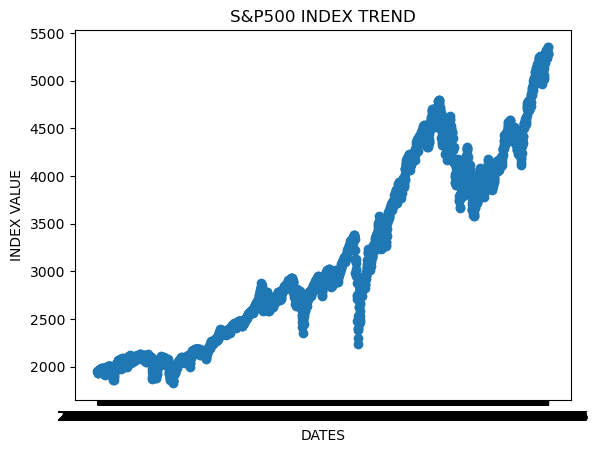

In [3]:
dates = sp500_index['Date']
index = sp500_index['S&P500']

plt.plot(dates, index, marker='o')
plt.title("S&P500 INDEX TREND")
plt.xlabel("DATES")
plt.ylabel("INDEX VALUE")

We can see a consistent upward Trend for most of its time, except in 2020 due to the pandemic

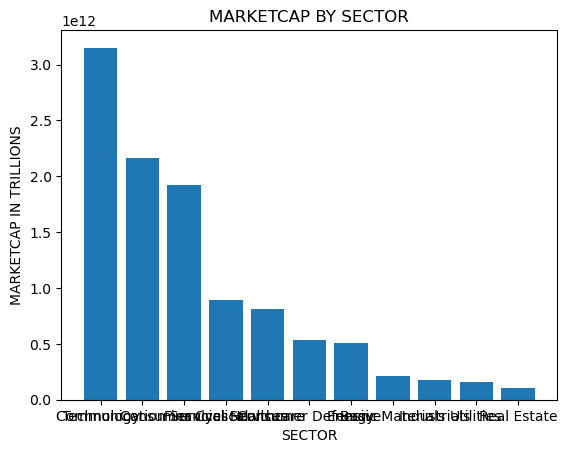

In [4]:
sp500_companies_sorted = sp500_companies.sort_values(by=["Marketcap"], ascending=False)

plt.bar(sp500_companies_sorted['Sector'], sp500_companies_sorted['Marketcap'])
plt.title('MARKETCAP BY SECTOR')
plt.xlabel('SECTOR')
plt.ylabel('MARKETCAP IN TRILLIONS')
plt.show()



The sectors with the highest market capitalization are Technology, Communication Services, and Financial Services. The sectors with the lowest market capitalization are Basic Materials, Utilities, and Real Estate.

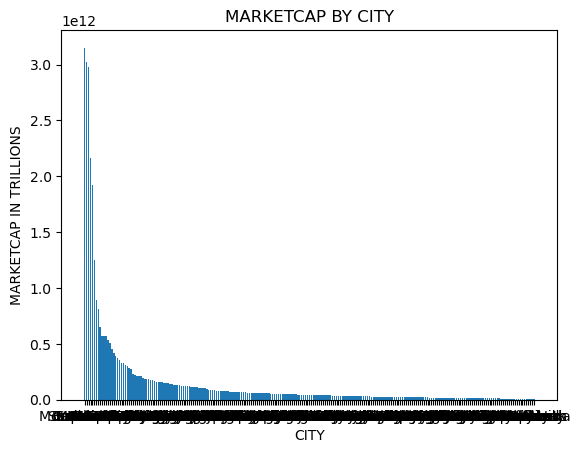

In [5]:
sp500_companies_sorted = sp500_companies.sort_values(by=["Marketcap"], ascending=False)

plt.bar(sp500_companies_sorted['City'], sp500_companies_sorted['Marketcap'])


plt.title('MARKETCAP BY CITY')
plt.xlabel('CITY')
plt.ylabel('MARKETCAP IN TRILLIONS')

plt.show()

In [6]:
sp500_companies[sp500_companies['State'].isnull()].head(3)
sp500_companies = sp500_companies.drop(['State'], axis=1)
sp500_companies.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,423.85,3150184448000,1.251820e+11,0.170,Redmond,United States,221000.0,Microsoft Corporation develops and supports so...,0.063205
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,196.89,3019131060224,1.296290e+11,-0.043,Cupertino,United States,150000.0,"Apple Inc. designs, manufactures, and markets ...",0.060576
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,1208.88,2973639376896,4.927500e+10,2.621,Santa Clara,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.059663
3,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,174.46,2164961443840,1.097230e+11,0.154,Mountain View,United States,180895.0,Alphabet Inc. offers various products and plat...,0.043438
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,175.95,2163622019072,1.097230e+11,0.154,Mountain View,United States,180895.0,Alphabet Inc. offers various products and plat...,0.043411


We have identified State Variable has NaN values and removed it because we will be conduction Stock Analysis by Country only

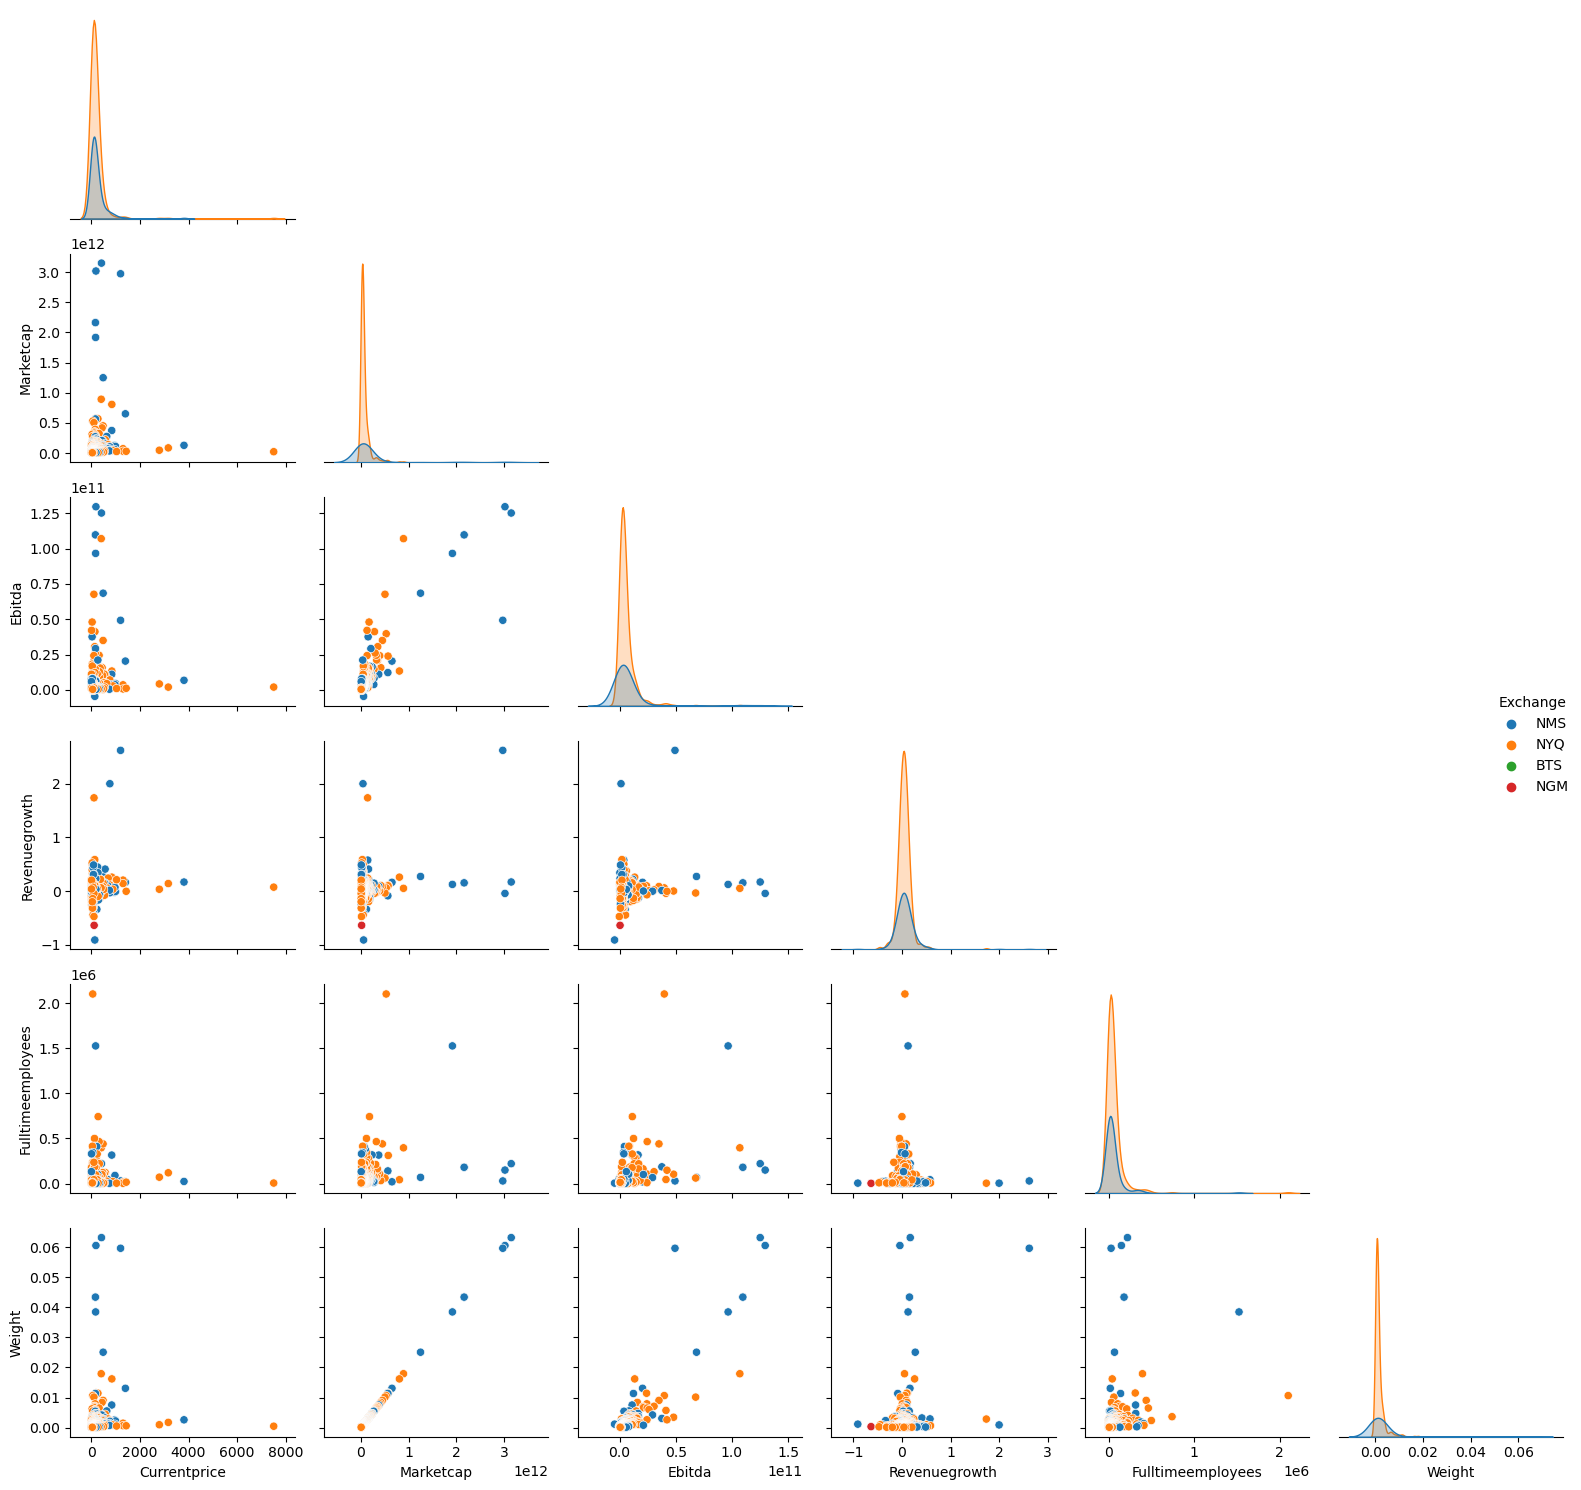

In [7]:
import seaborn as sns
sns.pairplot(sp500_companies, corner=True, hue='Exchange')
plt.tight_layout()


We can see a linear relationship between Marketcap and Weights (calculated from Marketcap).

In [8]:
sp500_stocks = pd.read_csv('/Users/keshavlodha/Downloads/ECS171_FINAL/data/sp500_stocks.csv')
sp500_companies = pd.read_csv('/Users/keshavlodha/Downloads/ECS171_FINAL/data/sp500_companies.csv')

In [9]:
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])
data = sp500_stocks.merge(sp500_companies, on='Symbol')
data = data.sort_values(['Symbol', 'Date'])

In [10]:
def calcualte_moving_avg(window, df = data, group_by_col = 'Symbol', target_col = 'Close'):  
    moving_averages = pd.Series(index=df.index, dtype=float)

    for group, group_df in df.groupby(group_by_col):
        group_rolling_mean = group_df[target_col].rolling(window=window).mean()
        moving_averages.loc[group_df.index] = group_rolling_mean

    return moving_averages

In [11]:
data['Prev_Close'] = data.groupby('Symbol')['Close'].shift(1)
data['Prev_Close'].fillna(method='bfill', inplace=True)

data['MA_5'] = calcualte_moving_avg(window=5)
data['MA_10'] = calcualte_moving_avg(window=10)
data['MA_20'] = calcualte_moving_avg(window=20)
data.fillna(method='bfill', inplace=True)


features = ['Prev_Close', 'MA_5', 'MA_10', 'MA_20']
target = 'Close'

In [12]:
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
joblib.dump(lr_model, '/Users/keshavlodha/Downloads/ECS171_FINAL/flask_ml_gui/LR_model.pkl')
y_pred_lr = lr_model.predict(X_test)
print(f"Linear Regression Mean Squared Error: {mean_squared_error(y_test, y_pred_lr)}")
print(f"Linear Regression Mean Squared Error: {r2_score(y_test, y_pred_lr)}")

Linear Regression Mean Squared Error: 17.589059979365558


In [14]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
joblib.dump(dt_model, '/Users/keshavlodha/Downloads/ECS171_FINAL/flask_ml_gui/DT_model.pkl')
y_pred_dt = dt_model.predict(X_test)
print(f"Decision Tree Mean Squared Error: {mean_squared_error(y_test, y_pred_dt)}")
print(f"Linear Regression Mean Squared Error: {r2_score(y_test, y_pred_lr)}")

Decision Tree Mean Squared Error: 31.477900632795357


In [23]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42) 
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, '/Users/keshavlodha/Downloads/ECS171_FINAL/flask_ml_gui/RF_model.pkl')
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Mean Squared Error: {mean_squared_error(y_test, y_pred_rf)}")
print(f"Linear Regression Mean Squared Error: {r2_score(y_test, y_pred_lr)}")

Random Forest Mean Squared Error: 18.651111826121276


In [15]:
def predict_stock_price_tomorrow(symbol):
    company_data = data[data['Symbol'] == symbol].sort_values('Date')
    if company_data.empty:
        return f"No data available for symbol: {symbol}"

    latest_data = company_data.iloc[-1]


    X_new = pd.DataFrame({
        'Prev_Close': [latest_data['Close']],
        'MA_5': [latest_data['MA_5']],
        'MA_10': [latest_data['MA_10']],
        'MA_20': [latest_data['MA_20']]
    })

    predicted_price_lr = lr_model.predict(X_new)[0]
    predicted_price_dt = dt_model.predict(X_new)[0]

    return {
        'Linear Regression': predicted_price_lr,
        'Decision Tree': predicted_price_dt,
    }

In [19]:
def plot_last_month(symbol):
    # Load stock data
    sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])
    
    # Filter the data for the given symbol and last month
    last_month = sp500_stocks[sp500_stocks['Symbol'] == symbol].tail(30)
    
    plt.figure(figsize=(10, 5))
    plt.plot(last_month['Date'], last_month['Close'], label='Close Price')
    plt.title(f'Last Month Stock Prices for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    
    # Save the plot
    plot_path = os.path.join('static', f'{symbol}_last_month.png') 
    plt.savefig(plot_path)
    plt.close()
    
    return plot_path

In [17]:
predict_stock_price_tomorrow("AAPL")

{'Linear Regression': 196.72912683920703, 'Decision Tree': 196.57000732421875}

In [21]:
plot_last_month("AAPL")


'/Users/keshavlodha/Downloads/ECS171_FINAL/flask_ml_gui/static/AAPL_last_month.png'